In [120]:
from matplotlib import pyplot as plt 
from sklearn.decomposition import PCA 
from sklearn.svm import SVC 
from sklearn.utils import resample
import os
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import cv2
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report

Defining target classes


In [121]:
target_classes = ['go', 'stop', 'warning']
color_map = {'go':'green', 'stop':'red', 'warning':'yellow'}
rgb_color_map = {'go': (0, 255, 0), 'stop': (255, 0, 0), 'warning': (255, 255, 0)}

train_folder_list = [
    'dayTrain',
#     'daySequence1',
#     'daySequence2',
#     'sample-dayClip6',
#     'nightTrain',
#     'nightSequence1',
#     'nightSequence2',
#     'sample-nightClip1',
]

n_samples_per_class = 1000

In [122]:

def get_annotarion_dataframe(train_data_folders):
    data_base_path = './input/lisa-traffic-light-dataset/'
    annotation_list = list()
    for folder in [folder + '/' for folder in train_data_folders if os.listdir(data_base_path)]:
        annotation_path = ''
        if 'sample' not in folder:
            annotation_path = data_base_path + 'Annotations/Annotations/' + folder
        else:
            annotation_path = data_base_path + folder*2
        image_frame_path = data_base_path + folder*2
        
        df = pd.DataFrame()
        if 'Clip' in os.listdir(annotation_path)[0]:
            clip_list = os.listdir(annotation_path)
            for clip_folder in clip_list:
                df = pd.read_csv(annotation_path + clip_folder +  '/frameAnnotationsBOX.csv', sep=";")
                df['image_path'] = image_frame_path + clip_folder + '/frames/'
                annotation_list.append(df)
        else:
            df = pd.read_csv(annotation_path +  'frameAnnotationsBOX.csv', sep=";")
            df['image_path'] = image_frame_path + 'frames/'
            annotation_list.append(df)
        
    df = pd.concat(annotation_list)
    df = df.drop(['Origin file', 'Origin frame number', 'Origin track', 'Origin track frame number'], axis=1)
    df.columns = ['filename', 'target', 'x1', 'y1', 'x2', 'y2', 'image_path']
    df = df[df['target'].isin(target_classes)]
    df['filename'] = df['filename'].apply(lambda filename: re.findall("\/([\d\w-]*.jpg)", filename)[0])
    df = df.drop_duplicates().reset_index(drop=True)
    return df

our train df looks like this

In [123]:
train_annotation_df = get_annotarion_dataframe(train_folder_list)

target_classes = train_annotation_df['target'].unique()
target_classes.sort()

train_annotation_df

,filename,target,x1,y1,x2,y2,image_path
0,dayClip1--00000.jpg,go,698,333,710,358,./input/lisa-traffic-light-dataset/dayTrain/da...
1,dayClip1--00000.jpg,go,846,391,858,411,./input/lisa-traffic-light-dataset/dayTrain/da...
2,dayClip1--00001.jpg,go,698,337,710,357,./input/lisa-traffic-light-dataset/dayTrain/da...
3,dayClip1--00001.jpg,go,847,390,859,410,./input/lisa-traffic-light-dataset/dayTrain/da...
4,dayClip1--00002.jpg,go,698,331,710,356,./input/lisa-traffic-light-dataset/dayTrain/da...
...,...,...,...,...,...,...,...
29693,dayClip9--00906.jpg,go,1139,157,1187,232,./input/lisa-traffic-light-dataset/dayTrain/da...
29694,dayClip9--00907.jpg,go,1159,153,1204,233,./input/lisa-traffic-light-dataset/dayTrain/da...
29695,dayClip9--00908.jpg,go,1185,150,1224,230,./input/lisa-traffic-light-dataset/dayTrain/da...
29696,dayClip9--00909.jpg,go,1199,141,1256,226,./input/lisa-traffic-light-dataset/dayTrain/da...


In [124]:
def resample_dataset(annotation_df, n_samples):
    df_resample_list = list()
    for target in target_classes:
        df = annotation_df[annotation_df['target'] == target].copy()
        df_r = resample(df, n_samples=n_samples, random_state=42)
        df_resample_list.append(df_r)
    return pd.concat(df_resample_list).reset_index(drop=True)

train_annotation_df = resample_dataset(train_annotation_df, n_samples_per_class)
train_annotation_df

,filename,target,x1,y1,x2,y2,image_path
0,dayClip5--00296.jpg,go,675,359,690,384,./input/lisa-traffic-light-dataset/dayTrain/da...
1,dayClip1--01560.jpg,go,660,322,672,342,./input/lisa-traffic-light-dataset/dayTrain/da...
2,dayClip2--00691.jpg,go,842,129,884,209,./input/lisa-traffic-light-dataset/dayTrain/da...
3,dayClip8--01037.jpg,go,1187,268,1238,318,./input/lisa-traffic-light-dataset/dayTrain/da...
4,dayClip2--00317.jpg,go,1248,337,1275,382,./input/lisa-traffic-light-dataset/dayTrain/da...
...,...,...,...,...,...,...,...
2995,dayClip7--00169.jpg,warning,1177,347,1204,383,./input/lisa-traffic-light-dataset/dayTrain/da...
2996,dayClip13--00201.jpg,warning,472,61,520,128,./input/lisa-traffic-light-dataset/dayTrain/da...
2997,dayClip7--00156.jpg,warning,944,294,962,321,./input/lisa-traffic-light-dataset/dayTrain/da...
2998,dayClip7--00122.jpg,warning,856,368,871,386,./input/lisa-traffic-light-dataset/dayTrain/da...


In [125]:
def image_traffic_light_crop(df):
    
    img_values = dict()
    for index in tqdm(df.index, total=len(df)):
        row = df.loc[index]
        image_path = row["image_path"]
        filename = row["filename"]
        target = row["target"]
        x1, x2, y1, y2 = row["x1"], row["x2"], row["y1"], row["y2"]
        img = cv2.imread(image_path + filename)
        cropped_img = img[y1:y2, x1:x2]
        cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
        img_values[index] = cropped_img
    return img_values

In [126]:
img_values = image_traffic_light_crop(train_annotation_df)

  0%|          | 0/3000 [00:00<?, ?it/s]

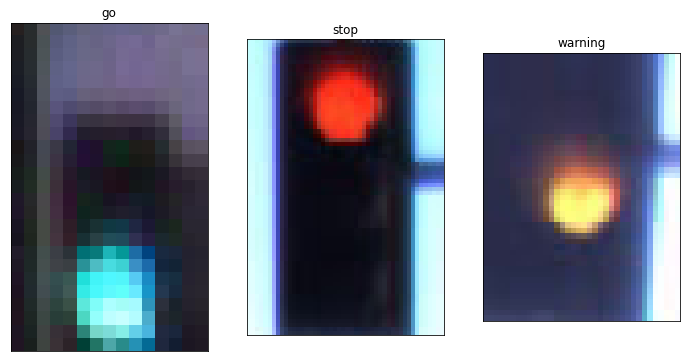

In [127]:
samples_imgs = dict()
for target in target_classes:
    index = train_annotation_df[train_annotation_df['target'] == target].index[0]
    img = img_values[index]
    samples_imgs[target] = img

_, axs = plt.subplots(1, len(target_classes), figsize=(12, 12))
axs = axs.flatten()
for target, ax in zip(samples_imgs, axs):
    ax.imshow(samples_imgs[target])
    ax.set_title(target)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.show()

In [128]:
from skimage.feature import hog
def image_hog(img_values):
    hog_img_values = dict()
    for index in tqdm(img_values, total=len(img_values)):
        img = img_values[index]
        img = cv2.resize(img, (30, 50))
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hog_descriptor,hog_image = hog(gray, orientations=8, pixels_per_cell=(16, 16),
                                cells_per_block=(1, 1), visualize=True)
        hog_img_values[index]=hog_image
    return hog_img_values

hog_img_values= image_hog(img_values)

  0%|          | 0/3000 [00:00<?, ?it/s]

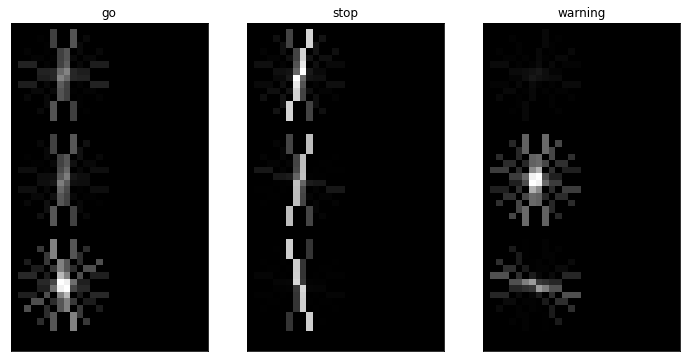

In [129]:

samples_imgs = dict()
for target in target_classes:
    index = train_annotation_df[train_annotation_df['target'] == target].index[0]
    img = hog_img_values[index]
    samples_imgs[target] = img
    
_, axs = plt.subplots(1, len(target_classes), figsize=(12, 12))
axs = axs.flatten()
for target, ax in zip(samples_imgs, axs):
    ax.imshow(samples_imgs[target], cmap="gray")
    ax.set_title(target)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.show()

In [130]:
def image_to_vector(binary_img_values, annotation_df):
    
    binary_img_vectors = dict()
    for index in tqdm(binary_img_values, total=len(binary_img_values)):
        img = binary_img_values[index]
        img_vector = np.c_[img.ravel()].transpose()[0]
        binary_img_vectors[index] = img_vector

    img_columns = ["p"+str(i) for i in range(1,1501)]
    df_img_values = pd.DataFrame(binary_img_vectors.values(), 
                                 index=binary_img_vectors.keys(), 
                                 columns=img_columns)
    return pd.merge(annotation_df, df_img_values, left_index=True, right_index=True)

df_img_values = image_to_vector(hog_img_values, train_annotation_df)
df_img_values.head()

  0%|          | 0/3000 [00:00<?, ?it/s]

,filename,target,x1,y1,x2,y2,image_path,p1,p2,p3,...,p1491,p1492,p1493,p1494,p1495,p1496,p1497,p1498,p1499,p1500
0,dayClip5--00296.jpg,go,675,359,690,384,./input/lisa-traffic-light-dataset/dayTrain/da...,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,dayClip1--01560.jpg,go,660,322,672,342,./input/lisa-traffic-light-dataset/dayTrain/da...,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,dayClip2--00691.jpg,go,842,129,884,209,./input/lisa-traffic-light-dataset/dayTrain/da...,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,dayClip8--01037.jpg,go,1187,268,1238,318,./input/lisa-traffic-light-dataset/dayTrain/da...,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,dayClip2--00317.jpg,go,1248,337,1275,382,./input/lisa-traffic-light-dataset/dayTrain/da...,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
X = df_img_values.drop(['filename', 'target', 'x1', 'y1', 'x2', 'y2', 'image_path'], axis=1)
y = df_img_values["target"]

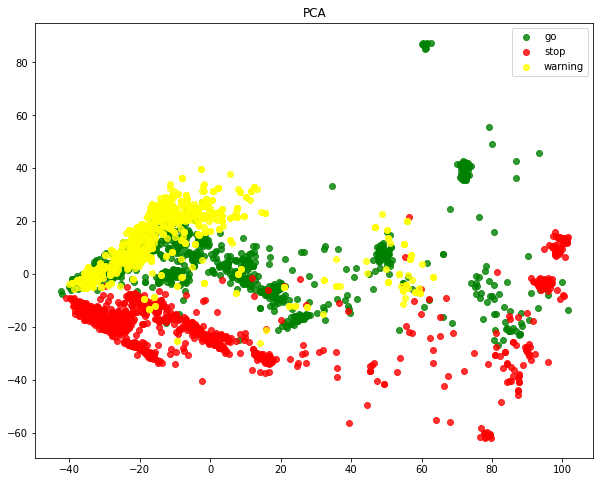

In [132]:
pca = PCA(n_components=2)
X_r = pca.fit_transform(X)
y_r = pd.Series(y.values.ravel())

plt.figure(figsize=(10,8))
for target in target_classes:
    plt.scatter(X_r[y_r == target, 0], 
                X_r[y_r == target, 1], 
                color=color_map[target], alpha=.8, label=target)
plt.legend(loc="best")
plt.title('PCA')
plt.show()

In [133]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [134]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train.values.ravel());

y_pred = dt.predict(X_test)
print(accuracy_score( y_test,y_pred))
print(classification_report(y_test, y_pred))

0.9786666666666667
              precision    recall  f1-score   support

          go       0.98      0.98      0.98       250
        stop       0.98      0.96      0.97       250
     warning       0.98      0.99      0.98       250

    accuracy                           0.98       750
   macro avg       0.98      0.98      0.98       750
weighted avg       0.98      0.98      0.98       750



In [135]:
lr = LogisticRegression(max_iter=500)
lr.fit(X_train, y_train.values.ravel());

y_pred = lr.predict(X_test)
print(accuracy_score( y_test,y_pred))
print(classification_report(y_test, y_pred))

0.9933333333333333
              precision    recall  f1-score   support

          go       0.99      1.00      0.99       250
        stop       0.99      0.99      0.99       250
     warning       1.00      1.00      1.00       250

    accuracy                           0.99       750
   macro avg       0.99      0.99      0.99       750
weighted avg       0.99      0.99      0.99       750



In [136]:
svc = SVC()
svc.fit(X_train, y_train.values.ravel());

y_pred = svc.predict(X_test)
print(accuracy_score( y_test,y_pred))
print(classification_report(y_test, y_pred))

0.9866666666666667
              precision    recall  f1-score   support

          go       0.99      0.98      0.99       250
        stop       0.98      0.98      0.98       250
     warning       1.00      0.99      0.99       250

    accuracy                           0.99       750
   macro avg       0.99      0.99      0.99       750
weighted avg       0.99      0.99      0.99       750



In [137]:

knn = KNeighborsClassifier()
knn.fit(X_train,  y_train.values.ravel())
y_pred= knn.predict(X_test)
print(accuracy_score( y_test,y_pred))
print(classification_report(y_test,y_pred))

0.9853333333333333
              precision    recall  f1-score   support

          go       0.98      0.98      0.98       250
        stop       0.98      0.98      0.98       250
     warning       1.00      0.99      0.99       250

    accuracy                           0.99       750
   macro avg       0.99      0.99      0.99       750
weighted avg       0.99      0.99      0.99       750



In [138]:
test_folder_list = [
#     'dayTrain',
    'daySequence1',
    'daySequence2',
    'sample-dayClip6',
#     'nightTrain',
#     'nightSequence1',
#     'nightSequence2',
#     'sample-nightClip1',
]

n_samples_per_class = 100

test_annotation_df = get_annotarion_dataframe(test_folder_list)
test_annotation_df = resample_dataset(test_annotation_df, n_samples_per_class)
img_values = image_traffic_light_crop(test_annotation_df)
image_hog = image_hog(img_values)
df_img_values = image_to_vector(image_hog, test_annotation_df)

X = df_img_values.drop(['filename', 'target', 'x1', 'y1', 'x2', 'y2', 'image_path'], axis=1)
y = df_img_values["target"]

y_pred = lr.predict(X)
print(classification_report(y, y_pred))
df_img_values['pred_target'] = y_pred

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

              precision    recall  f1-score   support

          go       0.86      0.83      0.85       100
        stop       0.91      0.89      0.90       100
     warning       0.89      0.94      0.91       100

    accuracy                           0.89       300
   macro avg       0.89      0.89      0.89       300
weighted avg       0.89      0.89      0.89       300



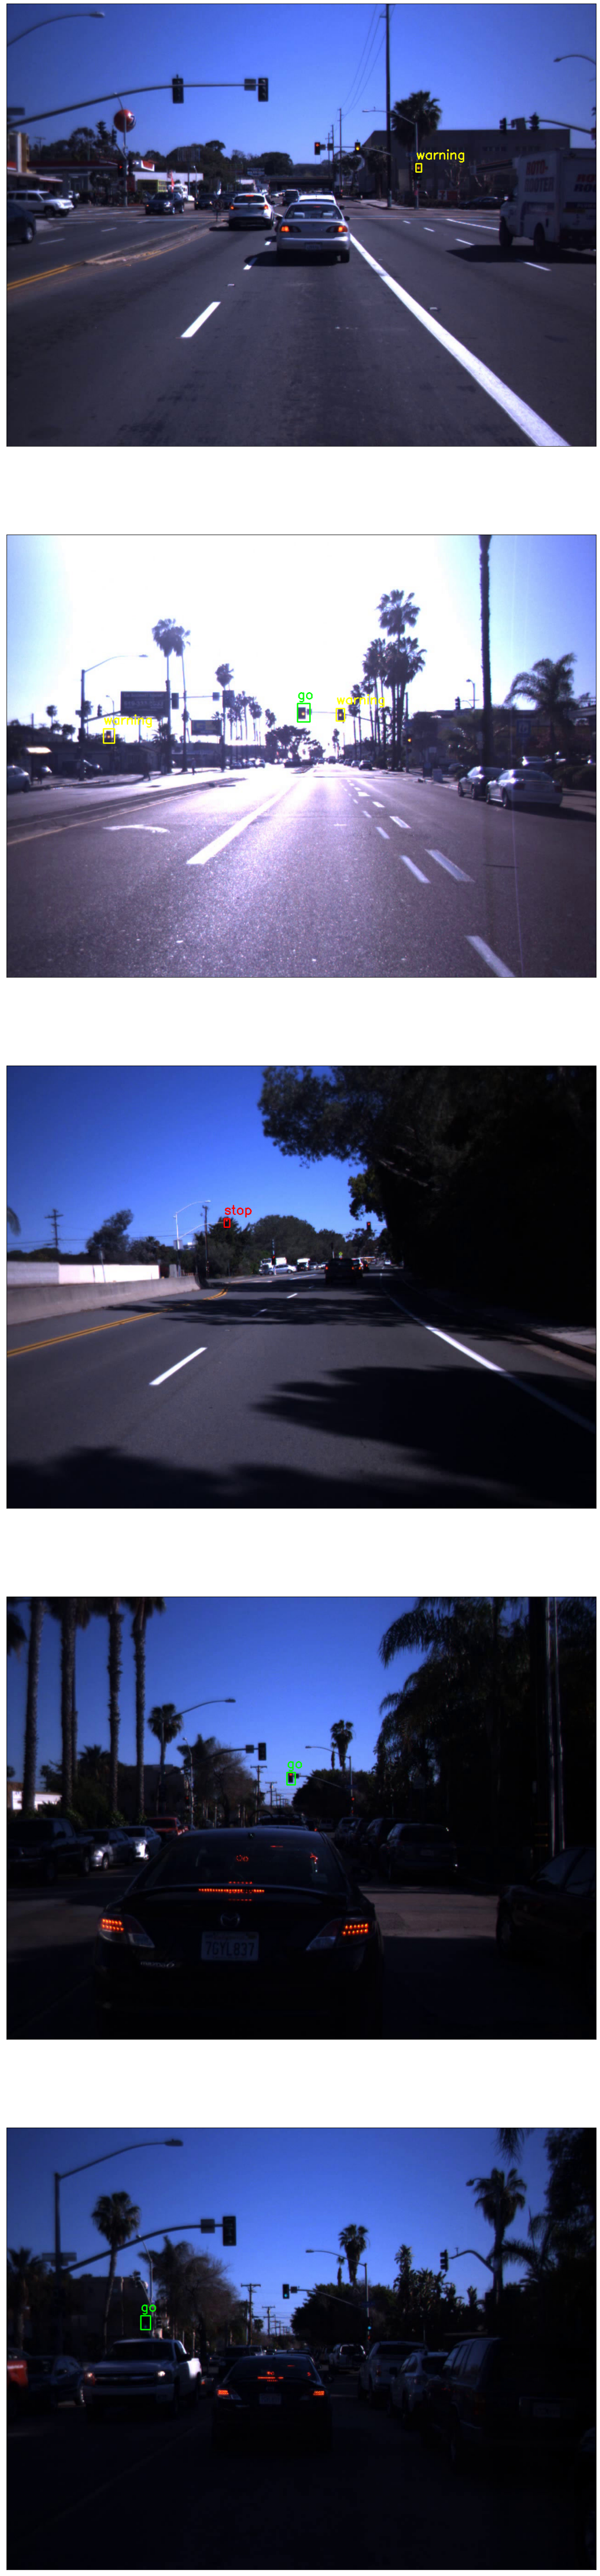

In [139]:
def show_image_with_label(df_sample, img_list):
    n_imgs = len(img_list)
    _, axs = plt.subplots(n_imgs, 1, figsize=(20*n_imgs, 16*n_imgs))
#     axs = axs.flatten()
    for filename, ax in zip(img_list, axs):
        df = df_sample[df_sample['filename'] == filename].copy()
        image_path = df['image_path'].values[0]
        img = cv2.imread(image_path + filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        for _, row in df.iterrows():
            target = row['pred_target']
            x1, x2, y1, y2 = row['x1'], row['x2'], row['y1'], row['y2']
            start_point = (x1, y1)
            end_point = (x2, y2)
            color = rgb_color_map[target]
            thickness = 2
            img = cv2.rectangle(img, start_point, end_point, color, thickness)
            img = cv2.putText(img, target, (x1, y1-10), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
        ax.imshow(img)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    plt.show()
    
sample_img_list = df_img_values['filename'].sample(5).values
show_image_with_label(df_img_values, sample_img_list)

In [140]:
import math
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import cv2
import time
from scipy.ndimage import filters
video_path = "./input/project.avi"
output_path  = "./input/output_video.avi"


In [141]:
cap = cv2.VideoCapture("C:\\Users\\u27d41\\Desktop\\TLR\\tl-detector\\TrafficLightClassification\\input\\lisa-traffic-light-dataset\\project.mp4")
# Define the Sobel filters in x and y directions
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

# Define the duration for video recording in seconds
record_duration = 15

# Define the codec for saving the video file
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# Get the dimensions of the frames
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create a video writer object to save the output video
out = cv2.VideoWriter('output_video.mp4', fourcc, 20.0, (2*width, height))

# Start the timer for recording
start_time = time.time()

while(cap.isOpened()):
    # Capture a frame from the webcam
    ret, frame = cap.read()
    
    if ret:
        # Convert to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)    

        # Apply Gaussian Blur to reduce noise
        gray_frame = cv2.GaussianBlur(gray, (3, 3), 0)

        # Apply the Sobel filters to the grayscale image
        sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

        # Obtain the gradient magnitude and orientation
        grad_mag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)

        # Normalize gradient magnitude to 0-255 range
        grad_mag_norm = cv2.normalize(grad_mag, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

        # Threshold the image to obtain binary edge map
        threshold_value = 25
        _, threshold_edge_map = cv2.threshold(grad_mag_norm, threshold_value, 255, cv2.THRESH_BINARY)

        # Concatenate the input frame and the gradient magnitude image side by side
        output_frame = np.concatenate((frame, cv2.cvtColor(grad_mag_norm, cv2.COLOR_GRAY2BGR)), axis=1)

        # Write the output frame to the video writer object
        out.write(output_frame)
        
        # Display the resulting frame
        cv2.imshow('Input', frame)
        cv2.imshow('Gradient Magnitude', grad_mag_norm)
        
        # Calculate the frame rate
        fps = 1.0 / (time.time() - start_time)

        # Display the frame rate on the input frame
        cv2.putText(frame, 'FPS: {:.2f}'.format(fps), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Break the loop if 'q' is pressed on the keyboard
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        # Stop recording if the specified duration is exceeded
        if time.time() - start_time > record_duration:
            break
    else:
        break

# Release the video capture and video writer objects
cap.release()
out.release()

# Close all windows
cv2.destroyAllWindows()
